In [ ]:
# colab 한글 폰트문제
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# tokenizer
!pip install konlpy

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import pickle

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# simbolic link
!ln -s /content/gdrive/My\ Drive/chat_bot/ReviewReactionBot /chat_bot
!ls /chat_bot

Mounted at /content/gdrive
checkpoints	preprocessing.ipynb  Seq2Seq_model.py
data		preprocessing.py     Seq2Seq_Transformer.ipynb
df_save.pkl	__pycache__	     small_transformer.png
lightning_logs	README.md	     soynlp_word_extractor.pkl
model_chp	requirements.txt     train_koGPT2.py
preprocessing	ReviewReactionBot    visualize.ipynb


In [4]:
class MyConfig(dict):
  def __getattr__(self, name): return self[name]
  def __setattr__(self, name, value): self[name] = value

configs = MyConfig({
    'path_drive' : Path('/chat_bot')
})
configs.datalist = [f for f in (configs.path_drive / 'data').glob('*') if 'pkl' in str(f)]



In [5]:
ff = ( pickle.load(open(f, 'rb')) for f in configs.datalist )
df = pd.concat(ff, axis=0, ignore_index=True)
df.tail()

,restaurant,review,answer,total,taste,quantity,delivery,location
646071,갈비&해물나라,...... ....,고객님의 첫 주문에 만족감을 드리지 못해 사과 드립니다. 하지만 다음에 주문 하실때...,5,3,4,5,강남구 신사동
646072,갈비&해물나라,양도 푸짐하니 많고 맛도 좋네요,맛있게 드시고 소중한 후기 남겨 주셔서 진심으로 감사드립니다. 언제나 고객님의 만족...,5,5,5,4,강남구 신사동
646073,갈비&해물나라,양도 많고 매콤하니 좋네요 술인주로 좋을듯,저희 닭도리탕은 압력솥으로 요리하기 때문에 고기가 연하고 부드럽습니다. 저희 음식점...,5,4,5,3,강남구 신사동
646074,갈비&해물나라,양도 많고 좋아요. 밥도 챙겨주시고 콜라도 주시구요. 50분 걸린다는 배달이 한시간...,주문이 밀리다 보니 고객님께 불편을 끼쳐드려 사과 드립니다. 저희 업소는 언제나 고...,5,,,,강남구 신사동
646075,반월식당,배달도 빨라서 좋았는데 맛도 좋습니다! 덕분에 든든한 저녁 잘먹었습니다~~~!,맛있는 리뷰 감사합니다 (❁ᴗ͈ˬᴗ͈)⁾⁾⁾ 매일 신선한 재료와 빠른 배달로 만족드...,5,5,5,5,강남구 신사동


In [6]:
# drop null review
df = df[~( ( df['review'].isnull() ) |  ( df['answer'].isnull() ) )]

## 별점분포
- total 값은 5점만 수집되었음(데이터 오류)
- `['taste','quantity','delivery']` 의 평균 점수를 사용
- 대부분의 별점이 4.3점 이상에 위치

In [7]:
df[['taste','quantity','delivery']] = df[['taste','quantity','delivery']].apply(pd.to_numeric)
df['star_avg'] = df.loc[:,['taste','quantity','delivery']].mean(axis=1)
df['star_avg'] = df['star_avg'].apply(lambda x: round(x,1))
# 별점 비율
df.star_avg.value_counts() / len(df)

5.0    0.707783
4.7    0.090460
4.3    0.059212
4.0    0.053668
3.7    0.025614
3.0    0.015159
3.3    0.013028
1.0    0.006906
2.3    0.005884
2.7    0.005738
2.0    0.003500
1.7    0.002078
1.3    0.001069
4.5    0.000180
3.5    0.000020
2.5    0.000018
1.5    0.000005
Name: star_avg, dtype: float64

In [96]:
df.star_avg.mean()

4.710981188454977

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


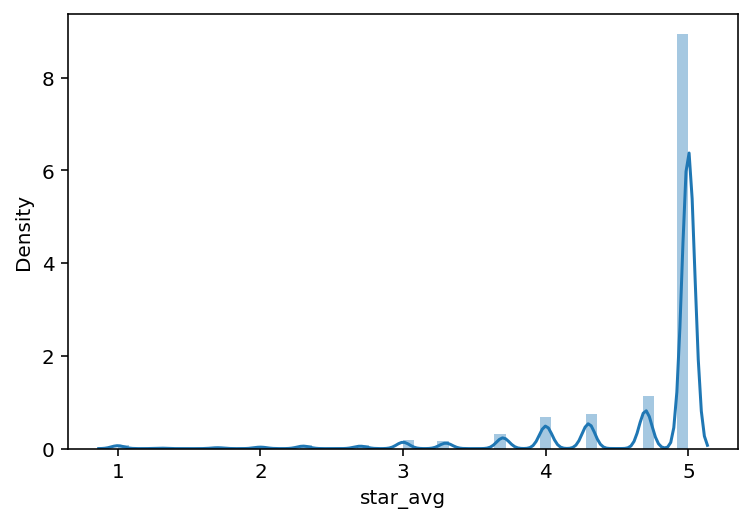

In [8]:
# simple visualize
sns.distplot(df.star_avg)

# 빈도기반 전처리
- 총 1523개 매장의 데이터
- 가장 리뷰가 많은 매장은 10883개 리뷰
- 가장 적은 매장은 1개
- 평균 리뷰 수는 401개

In [9]:
df['unique_word'] = df['answer'].apply(lambda x: str(x).split())
df['count_unique_word'] = df['unique_word'].apply(lambda x: len(x))

df['unique_name'] = df.restaurant+'-'+df.location
# 매장-위치 조합으로 unique - total 매장 수
print(f'Unique 매장 수 : {len(set(df.unique_name))}')

n_review_per_rest = df.groupby('unique_name')['answer'].count()

print(f'매장별 평균 리뷰 수 - {n_review_per_rest.values.mean()}')
print(f'가장 리뷰가 많은 매장 리뷰 수 - {n_review_per_rest.values.max()}')
print(f'가장 리뷰가 적은 매장 리뷰 수 - {n_review_per_rest.values.min()}')

Unique 매장 수 : 1523
매장별 평균 리뷰 수 - 401.61851608667104
가장 리뷰가 많은 매장 리뷰 수 - 10883
가장 리뷰가 적은 매장 리뷰 수 - 1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


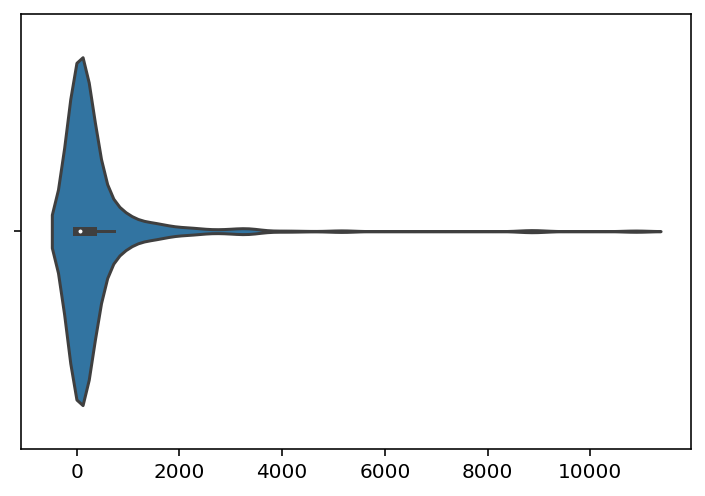

In [10]:
sns.violinplot(n_review_per_rest.values)

In [11]:
def counters(df):
  words = np.hstack(df.unique_word.values)
  unique_words = len(set(words))

  n_reviews = df.shape[0]
  return unique_words, n_reviews

def get_values(string, unique_restaurant_dict):
  return pd.Series(unique_restaurant_dict[f'{string}'])

# unique 매장 이름을 key로 갖는 dictionary
unique_restaurant_dict = dict.fromkeys(set(df.unique_name),0)
len(unique_restaurant_dict)

1523

In [12]:
# (리뷰에 사용된 Unique 단어 수) and (리뷰 수) per 매장 컬럼 생성
for k in unique_restaurant_dict.keys():
  # print(k)
  unique_words, n_reviews = counters(df[df.unique_name == k])
  unique_restaurant_dict[f'{k}'] = {'unique_vector': unique_words, 'n_reviews': n_reviews}


In [13]:
df_counter = df['unique_name'].apply(lambda x: get_values(x, unique_restaurant_dict))
df = pd.concat([df, df_counter], axis=1)
df.head()

,restaurant,review,answer,total,taste,quantity,delivery,location,star_avg,unique_word,count_unique_word,unique_name,unique_vector,n_reviews
12,부어치킨-세곡점,와 진짜 대박 맛있어서 암청 많이 먹다가 리뷰하는거 까먹어서 지금 남기네요 ㄷㄷㄷ ...,맛있게 드셨다니 저희도 정말 기쁩니다 ㅎㅎ 더 맛있고 정성스럽게 조리할테니 치킨 생...,5,5.0,5.0,5.0,강남구 세곡동,5.0,"[맛있게, 드셨다니, 저희도, 정말, 기쁩니다, ㅎㅎ, 더, 맛있고, 정성스럽게, ...",20,부어치킨-세곡점-강남구 세곡동,2420,1092
13,부어치킨-세곡점,치킨이 양이 적어보이는데 치킨 덩어리가 엄청커요!! 목덕후인 저는 목이 없어 슬프지...,소중한 사진 리뷰 감사합니다 ! 앞으로도 더 맛있는 음식으로 찾아뵐게요 ~~ 좋은 ...,5,4.0,4.0,4.0,강남구 세곡동,4.0,"[소중한, 사진, 리뷰, 감사합니다, !, 앞으로도, 더, 맛있는, 음식으로, 찾아...",16,부어치킨-세곡점-강남구 세곡동,2420,1092
14,부어치킨-세곡점,처음시켜 보는데 상담히 만족합니다. 배달 주문하기 힘드신 어머님이 부탁하셔서 시켜드...,첫 주문에 만족하셨다니 정말 다행이에요 ㅎㅎ 앞으로도 초심 잃지 않고 저희 모두 열...,5,5.0,5.0,5.0,강남구 세곡동,5.0,"[첫, 주문에, 만족하셨다니, 정말, 다행이에요, ㅎㅎ, 앞으로도, 초심, 잃지, ...",19,부어치킨-세곡점-강남구 세곡동,2420,1092
15,부어치킨-세곡점,맛있게 잘 먹었습니다,소중한 리뷰 감사합니다 ! 더 맛있고 정성스러운 음식으로 찾아뵐게요 좋은 하루 보내...,5,5.0,5.0,5.0,강남구 세곡동,5.0,"[소중한, 리뷰, 감사합니다, !, 더, 맛있고, 정성스러운, 음식으로, 찾아뵐게요...",13,부어치킨-세곡점-강남구 세곡동,2420,1092
16,부어치킨-세곡점,맛있었어요. 감사합니다.,맛있게 드셨다니 정말 다행이에요 감사합니다 ! 좋은 하루 보내시고 항상 건강하세요(...,5,5.0,5.0,5.0,강남구 세곡동,5.0,"[맛있게, 드셨다니, 정말, 다행이에요, 감사합니다, !, 좋은, 하루, 보내시고,...",11,부어치킨-세곡점-강남구 세곡동,2420,1092


### - 매장별로 리뷰에 사용된 Unique 단어 수를 기준으로 매크로 처럼 작성된 리뷰를 Cutoff

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


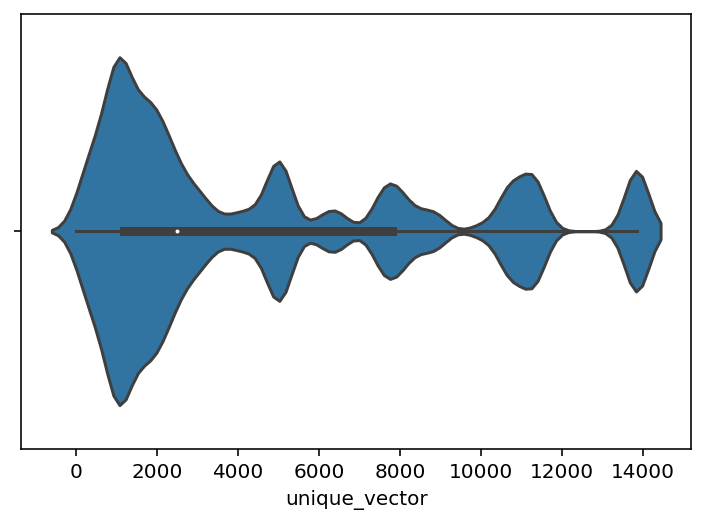

In [14]:
sns.violinplot(df.unique_vector)

In [15]:
# 500 개 이하 단어만 사용한 리뷰 Count
len([f for f in df[df.unique_vector < 500].answer])

34116

In [ ]:
[f for f in df[df.unique_vector < 500].answer]

In [19]:
df_unique = df[df.unique_vector > 500]
print(df.shape, df_unique.shape)

(611665, 14) (577549, 14)


In [20]:
!pip install soynlp

     |████████████████████████████████| 416 kB 8.1 MB/s 


In [21]:
df_unique.columns

Index(['restaurant', 'review', 'answer', 'total', 'taste', 'quantity',
       'delivery', 'location', 'star_avg', 'unique_word', 'count_unique_word',
       'unique_name', 'unique_vector', 'n_reviews'],
      dtype='object')

In [81]:
from soynlp import DoublespaceLineCorpus
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer
from soynlp.normalizer import emoticon_normalize, repeat_normalize

import re

class Regex_pattern():
  def __init__(self):
    self.user_name = re.compile(r'[A-Za-z\\**]+[님]') # user id 언급 -> 고객님
    self.emoticon_norm = emoticon_normalize
    self.repeat_norm = repeat_normalize
    self.punct = re.compile(r'[():><๑˃̵ᴗ˂̵/³˘※*_#=\-;:ㅁ@≧▽≦o]')

  def __call__(self, string):
    string = self.user_name.sub(r'고객님', string)
    string = self.emoticon_norm(string, num_repeats=3)
    string = self.repeat_norm(string, num_repeats=2)
    string = self.punct.sub('',string)
    return string


regex_pattern = Regex_pattern()



In [82]:
# 정규표현식 filter tester
test = 'su**님 *소중한 리뷰 감사합니다아아아아아아아아아! ㅋㅋㅋㅋㅋㅋㅋ큐ㅠㅠㅠㅠㅠㅠㅠ \
다음에도 맛있는 한 끼 드릴 수 있게 항상 최선을 다하겠습니다!※##=--;:ㅁ@≧▽≦o \
감사합니다 >_< 🚨 (๑˃̵ᴗ˂̵)/ 🚨 👉 1인분만주문해도 늘 맛있게만드는 정겨운 동네맛집이 되도록 노력하겠습니다~! \
요즘날씨가 많이추워졌습니다 감기조심하시구 언제나 🔥따뜻한🔥한끼식사 대접을위해 오늘도 열심히일하는 혼밥대왕이 되겠습니다 \
오늘도 이용해주신 고객님에게 무한한 감사를 표합니다 :) 늘 최선을다하는 정겨운 한식집이 되겠습니다~! ❤ 🌟 혼밥대왕 🌟'

regex_pattern(test)

'고객님 소중한 리뷰 감사합니다아아아! ㅋㅋㅋㅠㅠㅠ 다음에도 맛있는 한 끼 드릴 수 있게 항상 최선을 다하겠습니다! 감사합니다  🚨  🚨 👉 1인분만주문해도 늘 맛있게만드는 정겨운 동네맛집이 되도록 노력하겠습니다~! 요즘날씨가 많이추워졌습니다 감기조심하시구 언제나 🔥따뜻한🔥한끼식사 대접을위해 오늘도 열심히일하는 혼밥대왕이 되겠습니다 오늘도 이용해주신 고객님에게 무한한 감사를 표합니다  늘 최선을다하는 정겨운 한식집이 되겠습니다~! ❤ 🌟 혼밥대왕 🌟'

In [28]:
df_unique['name'] = df_unique['unique_name'].apply(lambda x: ' '.join(str(x).split('-')) )
df_unique['answer_clean'] = df_unique['answer'].apply(lambda x: regex_pattern(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# training soynlp word_extractor
sentences = list(df_unique.answer_clean) + list(df_unique.review) + list(set(df_unique.name))

word_extractor = WordExtractor(min_frequency=100,
    min_cohesion_forward=0.05, 
    min_right_branching_entropy=0.0
)
word_extractor.train(sentences) # list of str or like
words = word_extractor.extract()

# save word_score
with open(configs.path_drive / 'soynlp_word_extractor.pkl','wb') as f:
  pickle.dump(words, f)

training was done. used memory 6.545 Gb
all cohesion probabilities was computed. # words = 47134
all branching entropies was computed # words = 1111184
all accessor variety was computed # words = 1111184


In [25]:
with open(configs.path_drive / 'soynlp_word_extractor.pkl','rb') as f:
  words = pickle.load(f)

In [26]:
# Ltokenizer with trained cohesion_score
cohesion_score = {word:score.cohesion_forward for word, score in words.items()}
tokenizer = LTokenizer(scores=cohesion_score)

In [30]:
df_unique.head()[:2]

,restaurant,review,answer,total,taste,quantity,delivery,location,star_avg,unique_word,count_unique_word,unique_name,unique_vector,n_reviews,name,answer_clean
12,부어치킨-세곡점,와 진짜 대박 맛있어서 암청 많이 먹다가 리뷰하는거 까먹어서 지금 남기네요 ㄷㄷㄷ ...,맛있게 드셨다니 저희도 정말 기쁩니다 ㅎㅎ 더 맛있고 정성스럽게 조리할테니 치킨 생...,5,5.0,5.0,5.0,강남구 세곡동,5.0,"[맛있게, 드셨다니, 저희도, 정말, 기쁩니다, ㅎㅎ, 더, 맛있고, 정성스럽게, ...",20,부어치킨-세곡점-강남구 세곡동,2420,1092,부어치킨 세곡점 강남구 세곡동,맛있게 드셨다니 저희도 정말 기쁩니다 ㅎㅎ 더 맛있고 정성스럽게 조리할테니 치킨 생...
13,부어치킨-세곡점,치킨이 양이 적어보이는데 치킨 덩어리가 엄청커요!! 목덕후인 저는 목이 없어 슬프지...,소중한 사진 리뷰 감사합니다 ! 앞으로도 더 맛있는 음식으로 찾아뵐게요 ~~ 좋은 ...,5,4.0,4.0,4.0,강남구 세곡동,4.0,"[소중한, 사진, 리뷰, 감사합니다, !, 앞으로도, 더, 맛있는, 음식으로, 찾아...",16,부어치킨-세곡점-강남구 세곡동,2420,1092,부어치킨 세곡점 강남구 세곡동,소중한 사진 리뷰 감사합니다 ! 앞으로도 더 맛있는 음식으로 찾아뵐게요 ~~ 좋은 ...


In [ ]:
# 직접 Tokenizer 확인 with random sampling
def print_token(df_unique):
  for review,answer,name in zip(df_unique.review,df_unique.answer_clean,df_unique.name):
    name_filter = tokenizer( str(name))
    answer_filter = tokenizer(str(answer))
    re_answer = []
    for a in answer_filter:
      if a in name_filter:
        a = '매장'
        re_answer.append(a)
      else :
        re_answer.append(a)

    print(f'{review}\n {name}\n {answer}\n {tokenizer( str(name)) }\n{ tokenizer(str(answer)) }\n{re_answer}\n' )

print_token(df_unique.sample(500))

In [36]:
def tokenizer_with_filter(name,answer):
  
  name = name.replace('-',' ')

  name_filter = tokenizer(str(name))
  answer_filter = tokenizer(str(answer))
  re_answer = []

  for a in answer_filter:
    if a in name_filter:
      a = '매장'
      re_answer.append(a)
    else :
      re_answer.append(a)

  return re_answer

In [84]:
df_unique['soy_token_answer'] = ( df_unique[['unique_name','answer_clean']]
                                  .apply(lambda x: tokenizer_with_filter(*x), axis=1) )

df_unique['soy_token_review'] = df_unique['review'].apply(tokenizer) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
df_unique.head()[:2]

,restaurant,review,answer,total,taste,quantity,delivery,location,star_avg,unique_word,count_unique_word,unique_name,unique_vector,n_reviews,name,answer_clean,soy_token_answer,soy_token_review
12,부어치킨-세곡점,와 진짜 대박 맛있어서 암청 많이 먹다가 리뷰하는거 까먹어서 지금 남기네요 ㄷㄷㄷ ...,맛있게 드셨다니 저희도 정말 기쁩니다 ㅎㅎ 더 맛있고 정성스럽게 조리할테니 치킨 생...,5,5.0,5.0,5.0,강남구 세곡동,5.0,"[맛있게, 드셨다니, 저희도, 정말, 기쁩니다, ㅎㅎ, 더, 맛있고, 정성스럽게, ...",20,부어치킨-세곡점-강남구 세곡동,2420,1092,부어치킨 세곡점 강남구 세곡동,맛있게 드셨다니 저희도 정말 기쁩니다 ㅎㅎ 더 맛있고 정성스럽게 조리할테니 치킨 생...,"[맛있, 게, 드셨다니, 저희, 도, 정말, 기쁩니다, ㅎㅎ, 더, 맛있, 고, 정...","[와, 진짜, 대박, 맛있, 어서, 암청, 많이, 먹다가, 리뷰, 하는거, 까먹어서..."
13,부어치킨-세곡점,치킨이 양이 적어보이는데 치킨 덩어리가 엄청커요!! 목덕후인 저는 목이 없어 슬프지...,소중한 사진 리뷰 감사합니다 ! 앞으로도 더 맛있는 음식으로 찾아뵐게요 ~~ 좋은 ...,5,4.0,4.0,4.0,강남구 세곡동,4.0,"[소중한, 사진, 리뷰, 감사합니다, !, 앞으로도, 더, 맛있는, 음식으로, 찾아...",16,부어치킨-세곡점-강남구 세곡동,2420,1092,부어치킨 세곡점 강남구 세곡동,소중한 사진 리뷰 감사합니다 ! 앞으로도 더 맛있는 음식으로 찾아뵐게요 ~~ 좋은 ...,"[소중한, 사진, 리뷰, 감사, 합니다, !, 앞으로, 도, 더, 맛있, 는, 음식...","[치킨, 이, 양이, 적어, 보이는데, 치킨, 덩어리, 가, 엄청, 커요!!, 목덕..."


In [87]:
# save word_score
with open(configs.path_drive / 'df_save.pkl','wb') as f:
  pickle.dump(df_unique, f)

# with open(configs.path_drive / 'df_save.pkl','rb') as f:
#   df_unique = pickle.load(f)

# 토큰 EDA

In [88]:
df_unique['n_token_review'] = df_unique['soy_token_review'].apply(lambda x: len(x))
df_unique['n_token_answer'] = df_unique['soy_token_answer'].apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
pd.melt(df_unique[['n_token_review','n_token_answer']], id_vars=['n_token_review','n_token_answer'])

,n_token_review,n_token_answer,variable,value


In [89]:
df_unique[['n_token_review','n_token_answer','star_avg']].describe()

,n_token_review,n_token_answer,star_avg
count,577549.000000,577549.000000,572915.000000
mean,14.144566,38.445753,4.710782
std,13.953964,22.148639,0.636215
min,1.000000,0.000000,1.000000
25%,5.000000,21.000000,4.700000
50%,9.000000,34.000000,5.000000
75%,18.000000,55.000000,5.000000
max,159.000000,105.000000,5.000000


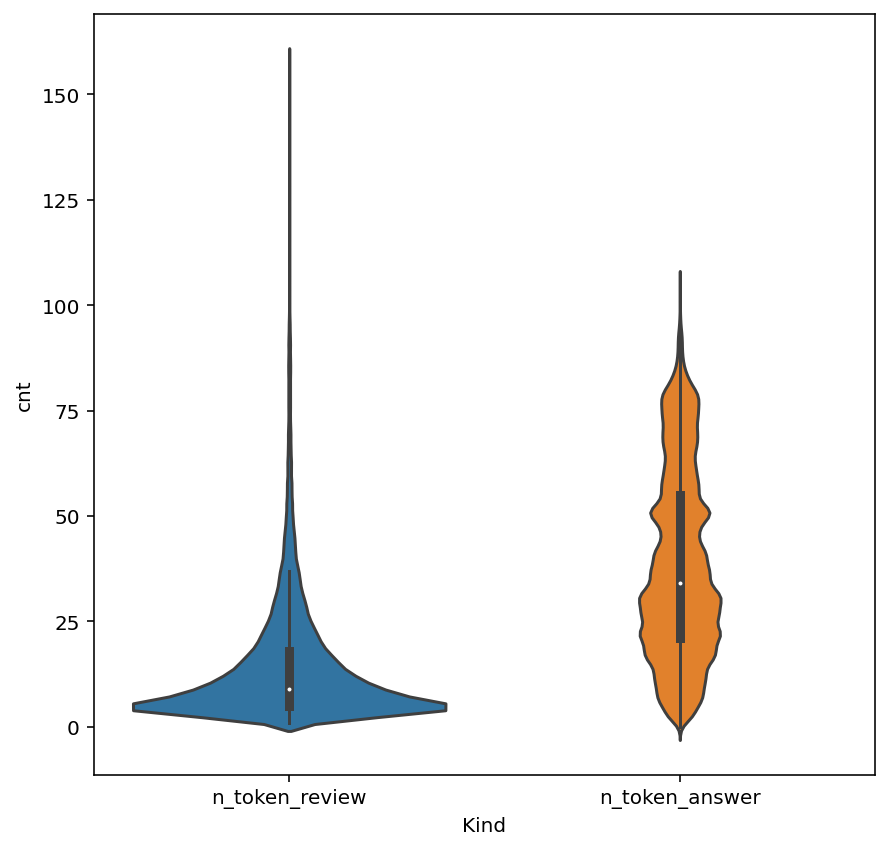

In [94]:
# Visualize token size
df_plt = df_unique[['n_token_review','n_token_answer']].stack().reset_index().rename(columns={'level_1': 'Kind',0:'cnt'})
plt.figure(figsize=(7,7))
sns.violinplot(data=df_plt, x='Kind', y='cnt')

In [95]:
df_unique.star_avg.mean()

4.710781704092879

In [97]:
def binary_score(x):
  if x >=4.7:
    return 'Above avg'
  else : return 'Below avg'
  
df_unique['binary_score'] = df_unique['star_avg'].apply(binary_score)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[Text(0.5, 0, 'Token Kinds'), Text(0.5, 1.0, 'Score < 4.5')]

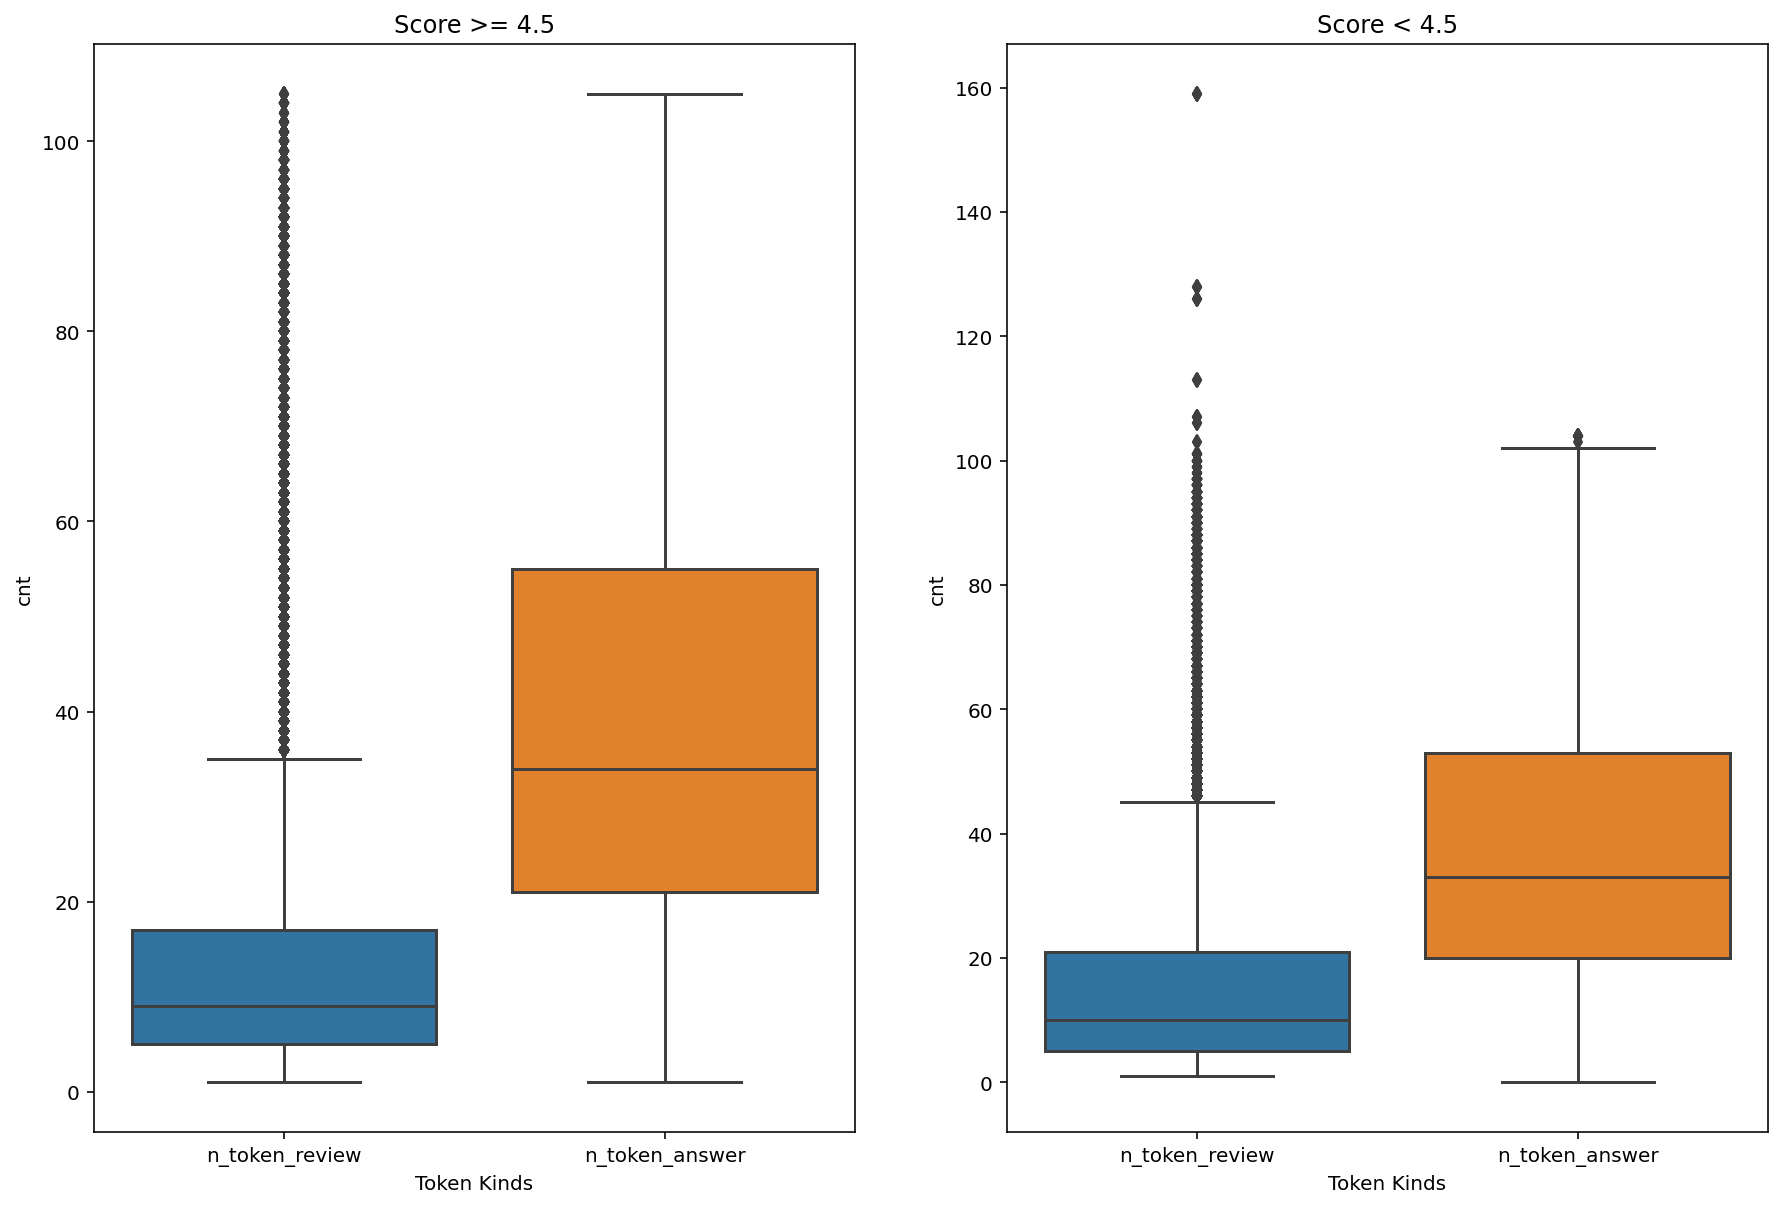

In [98]:
# Visualize token size group by binary_score
fig, ax = plt.subplots(1,2,figsize=(15,10))

sns.boxplot(data=(df_unique
                    .loc[df_unique.binary_score == 'Above avg',['n_token_review','n_token_answer']]
                    .stack()
                    .reset_index()
                    .rename(columns={'level_1': 'Kind',0:'cnt'}))
              , x='Kind', y='cnt', ax=ax[0])  

sns.boxplot(data=(df_unique
                    .loc[df_unique.binary_score == 'Below avg',['n_token_review','n_token_answer']]
                    .stack()
                    .reset_index()
                    .rename(columns={'level_1': 'Kind',0:'cnt'}))
              , x='Kind', y='cnt', ax=ax[1])  

ax[0].set(xlabel='Token Kinds', title="Score >= 4.5")
ax[1].set(xlabel='Token Kinds', title="Score < 4.5")

In [99]:
print(df_unique.loc[df_unique.binary_score == 'Above avg',['n_token_review','n_token_answer']].describe())
print(df_unique.loc[df_unique.binary_score == 'Below avg',['n_token_review','n_token_answer']].describe())

       n_token_review  n_token_answer
count   461561.000000   461561.000000
mean        13.605474       38.606719
std         13.222825       22.051609
min          1.000000        1.000000
25%          5.000000       21.000000
50%          9.000000       34.000000
75%         17.000000       55.000000
max        105.000000      105.000000
       n_token_review  n_token_answer
count   115988.000000   115988.000000
mean        16.289823       37.805204
std         16.371532       22.519318
min          1.000000        0.000000
25%          5.000000       20.000000
50%         10.000000       33.000000
75%         21.000000       53.000000
max        159.000000      104.000000


In [107]:
df_unique.loc[df_unique.binary_score == 'Below avg',['n_token_review','n_token_answer']].describe()

,n_token_review,n_token_answer
count,115988.000000,115988.000000
mean,16.289823,37.805204
std,16.371532,22.519318
min,1.000000,0.000000
25%,5.000000,20.000000
50%,10.000000,33.000000
75%,21.000000,53.000000
max,159.000000,104.000000


## Visualize by word cloud

In [100]:
!pip install wordcloud

In [101]:
from collections import Counter
from wordcloud import WordCloud

def word_cnt(df, stopwords):
  words = np.hstack(df_unique[df_unique.binary_score=='Below avg']['soy_token_review'])
  return Counter([w for w in words if w not in stopwords])


In [102]:
stopwords = ['요', '도', '는', '다', '의', '가', '이', '은', '한', 
             '에', '하', '고', '을', '를', '인', '듯', '과', '와', 
             '네', '들', '듯', '지', '임', '게','.','....','어요',
             '..','하고','서']

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


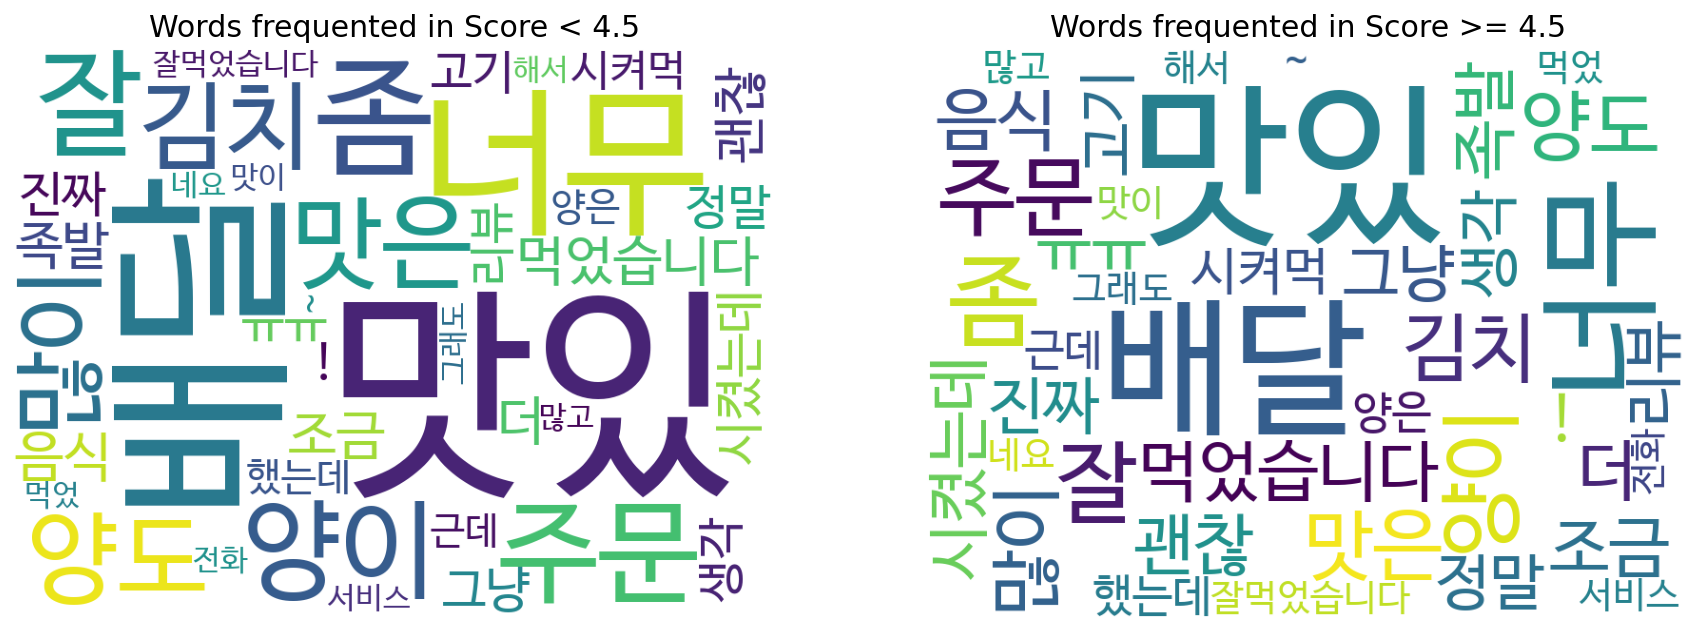

In [103]:
configs.plt_fontsize = 15
configs.n_common_words = 40

plt.figure(figsize=(15,12))
plt.subplot(121)
wc = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)

cloud_data = word_cnt(df_unique[df_unique.binary_score=='Below avg']['soy_token_review']
                      ,stopwords)

cloud = wc.generate_from_frequencies(dict(cloud_data.most_common(configs.n_common_words)))
plt.title("Words frequented in Score < 4.5", fontsize=configs.plt_fontsize)
plt.axis('off')
plt.imshow(cloud)

plt.subplot(122)
wc = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)

cloud_data = word_cnt(df_unique[df_unique.binary_score=='Above avg']['soy_token_review']
                      ,stopwords)

cloud = wc.generate_from_frequencies(dict(cloud_data.most_common(configs.n_common_words)))
plt.title("Words frequented in Score >= 4.5", fontsize=configs.plt_fontsize)
plt.axis('off')
plt.imshow(cloud)

In [ ]:
df_unique['Q'] = df_unique['soy_token_review'].apply(lambda x: ' '.join(x))
df_unique['A'] = df_unique['soy_token_answer'].apply(lambda x: ' '.join(x))
df_unique.head()

In [ ]:
configs

{'datalist': [PosixPath('/chat_bot/data/df_강남구_세곡동.pkl'),
  PosixPath('/chat_bot/data/df_강남구_개포동.pkl'),
  PosixPath('/chat_bot/data/df_강남구_자곡동.pkl'),
  PosixPath('/chat_bot/data/df_송파구_송파1동.pkl'),
  PosixPath('/chat_bot/data/df_송파구_송파2동.pkl'),
  PosixPath('/chat_bot/data/df_송파구_석촌동.pkl'),
  PosixPath('/chat_bot/data/df_송파구_문정1동.pkl'),
  PosixPath('/chat_bot/data/df_송파구_문정2동.pkl'),
  PosixPath('/chat_bot/data/df_송파구_오륜동.pkl'),
  PosixPath('/chat_bot/data/df_송파구_오금동.pkl'),
  PosixPath('/chat_bot/data/df_종로구_사직동.pkl'),
  PosixPath('/chat_bot/data/df_종로구_삼청동.pkl'),
  PosixPath('/chat_bot/data/df_종로구_부암동.pkl'),
  PosixPath('/chat_bot/data/df_강남구_청담동.pkl'),
  PosixPath('/chat_bot/data/df_종로구_평창동.pkl'),
  PosixPath('/chat_bot/data/df_강남구_삼성동.pkl'),
  PosixPath('/chat_bot/data/df_종로구_무악동.pkl'),
  PosixPath('/chat_bot/data/df_강남ᄀ

In [105]:
df_unique[['Q','A','star_avg']].to_csv(configs.path_drive / 'data' / 'ChatbotData_v2.csv')